In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available! Using CPU.")

CUDA is available! Using GPU.


In [4]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import os
import sys

__all__ = ['InceptionResNetV2', 'inceptionresnetv2']

pretrained_settings = {
    'inceptionresnetv2': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_5b(nn.Module):

    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = BasicConv2d(192, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=1, stride=1),
            BasicConv2d(48, 64, kernel_size=5, stride=1, padding=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super(Block35, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(320, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 48, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48, 64, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(128, 320, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super(Mixed_6a, self).__init__()

        self.branch0 = BasicConv2d(320, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super(Block17, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(1088, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 160, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(384, 1088, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super(Mixed_7a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=1, padding=1),
            BasicConv2d(288, 320, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(2080, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(2080, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(448, 2080, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class InceptionResNetV2(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionResNetV2, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.maxpool_5a = nn.MaxPool2d(3, stride=2)
        self.mixed_5b = Mixed_5b()
        self.repeat = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_1 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_2 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )
        self.block8 = Block8(noReLU=True)
        self.conv2d_7b = BasicConv2d(2080, 1536, kernel_size=1, stride=1)
        self.avgpool_1a = nn.AvgPool2d(8, count_include_pad=False)
        self.last_linear = nn.Linear(1536, num_classes)

    def features(self, input):
        x = self.conv2d_1a(input)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.maxpool_5a(x)
        x = self.mixed_5b(x)
        x = self.repeat(x)
        x = self.mixed_6a(x)
        x = self.repeat_1(x)
        x = self.mixed_7a(x)
        x = self.repeat_2(x)
        x = self.block8(x)
        x = self.conv2d_7b(x)
        return x

    def logits(self, features):
        x = self.avgpool_1a(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

def inceptionresnetv2(num_classes=1000, pretrained='imagenet'):
    r"""InceptionResNetV2 model architecture from the
    `"InceptionV4, Inception-ResNet..." <https://arxiv.org/abs/1602.07261>`_ paper.
    """
    if pretrained:
        settings = pretrained_settings['inceptionresnetv2'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionResNetV2(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']

        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionResNetV2(num_classes=num_classes)
    return model
model = inceptionresnetv2(num_classes=1000, pretrained='imagenet')
    

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth
100%|██████████| 213M/213M [10:28<00:00, 356kB/s]


In [5]:
model.last_linear = nn.Linear(1536,512)
nn.init.xavier_uniform_(model.last_linear.weight)
nn.init.constant_(model.last_linear.bias, 0)
for param in model.parameters():
    param.requires_grad = False
for param in model.last_linear.parameters():
    param.requires_grad = True
def list_parameters(model):
    print("Parameter List:")
    for name, param in model.named_parameters():
        print(f"Name: {name}, Requires Grad: {param.requires_grad}")
list_parameters(model)


Parameter List:
Name: conv2d_1a.conv.weight, Requires Grad: False
Name: conv2d_1a.bn.weight, Requires Grad: False
Name: conv2d_1a.bn.bias, Requires Grad: False
Name: conv2d_2a.conv.weight, Requires Grad: False
Name: conv2d_2a.bn.weight, Requires Grad: False
Name: conv2d_2a.bn.bias, Requires Grad: False
Name: conv2d_2b.conv.weight, Requires Grad: False
Name: conv2d_2b.bn.weight, Requires Grad: False
Name: conv2d_2b.bn.bias, Requires Grad: False
Name: conv2d_3b.conv.weight, Requires Grad: False
Name: conv2d_3b.bn.weight, Requires Grad: False
Name: conv2d_3b.bn.bias, Requires Grad: False
Name: conv2d_4a.conv.weight, Requires Grad: False
Name: conv2d_4a.bn.weight, Requires Grad: False
Name: conv2d_4a.bn.bias, Requires Grad: False
Name: mixed_5b.branch0.conv.weight, Requires Grad: False
Name: mixed_5b.branch0.bn.weight, Requires Grad: False
Name: mixed_5b.branch0.bn.bias, Requires Grad: False
Name: mixed_5b.branch1.0.conv.weight, Requires Grad: False
Name: mixed_5b.branch1.0.bn.weight, Requ

## Dataloader

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from torch.utils.data import dataset
from torch import nn, Tensor
# df = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')
# captions = df['caption']
# train_iter = iter(captions)

# tokenizer = get_tokenizer('basic_english')
# vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
# vocab.set_default_index(vocab['<unk>'])
# print(vocab)

# def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
#     """Converts raw text into a flat Tensor."""
#     data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
#     return data

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
from torch.utils.data import dataset

df = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')
captions = df['caption']
train_iter = iter(captions)

tokenizer = get_tokenizer('basic_english')

# Define the vocabulary with the special token '<pad>'
specials = ['<unk>', '<pad>']
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=specials)
vocab.set_default_index(vocab['<unk>'])
max_len = max(len(tokenizer(item)) for item in captions)
max_len = max(max_len,512)
print(max_len)
def data_process(raw_text_iter, vocab):
    """Converts raw text into a flat Tensor."""
    data = []
    for item in raw_text_iter:
        tokens = [vocab[token] for token in tokenizer(item)]
        # Pad the tokens to ensure uniform length
        padded_tokens = tokens + [vocab['<pad>']] * (max_len - len(tokens))
        data.append(torch.tensor(padded_tokens, dtype=torch.long))
    return data

# Calculate the maximum length of tokens in the dataset



# print(vocab)
# print(processed_data)


512


In [7]:
train_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv')['caption']
train_iter = iter(train_captions)
test_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv')['caption']
test_iter = iter(test_captions)
val_captions = pd.read_csv('/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv')['caption']
val_iter = iter(val_captions)
train_data = data_process(train_iter,vocab)
val_data = data_process(val_iter,vocab)
test_data = data_process(test_iter,vocab)
#print(train_data)

In [8]:
# class CustomDataset(Dataset):
#     def __init__(self, image_folder, csv_file, transform=None):
#         self.image_folder = image_folder
#         self.data = pd.read_csv(csv_file)
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         img_name = os.path.join(self.image_folder, self.data.iloc[idx, 1])
#         image = Image.open(img_name).convert("RGB")
#         caption = self.data.iloc[idx, 2]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, caption
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, image_folder, captions, csv_file, transform=None):
        self.image_folder = image_folder
        self.captions = captions
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB")
        caption = self.captions[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, caption


# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# from torchvision import transforms

# class CustomDataset(Dataset):
#     def __init__(self, image_folder, csv_file, transform=None, max_caption_length=1500):
#         self.image_folder = image_folder
#         self.data = pd.read_csv(csv_file)
#         self.transform = transform
#         self.max_caption_length = max_caption_length
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         img_name = os.path.join(self.image_folder, self.data.iloc[idx, 1])
#         image = Image.open(img_name).convert("RGB")
#         caption = self.data.iloc[idx, 2]
#         words = caption.split()
#         words = [word if word != '.' else '<SEP>' for word in words]
#         for i in range(len(words) - 1):
#             if words[i] == '<SEP>' and words[i + 1] != '<SEP>':
#                 words.insert(i + 1, '<EOS>')
#         if words[-1] != '<EOS>':
#             words.append('<EOS>')
#         words = words[:self.max_caption_length]
#         words += ['<PAD>'] * (self.max_caption_length - len(words))
        
#         caption = words
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, caption


In [9]:
import os
from PIL import Image
import pandas as pd

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train'
# csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv'
# train_dataset = CustomDataset(image_folder, csv_file, transform=transform)

# image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test'
# csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv'
# test_dataset = CustomDataset(image_folder, csv_file, transform=transform)

# image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val'
# csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv'
# validation_dataset = CustomDataset(image_folder, csv_file, transform=transform)

# batch_size = 4
# train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/train.csv'
train_dataset = CustomDataset(image_folder, train_data, csv_file, transform=transform)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/test.csv'
test_dataset = CustomDataset(image_folder, test_data, csv_file, transform=transform)

image_folder = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val'
csv_file = '/kaggle/input/deep-learning-term-project/custom_captions_dataset/val.csv'
validation_dataset = CustomDataset(image_folder, val_data, csv_file, transform=transform)

batch_size = 4
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)


Sample 1:


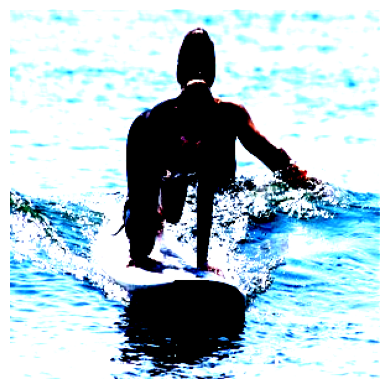

there is a woman wearing a black wet suit . she is standing in top of a white surf board . there is another person in the water behind her . there are small waves in the water .


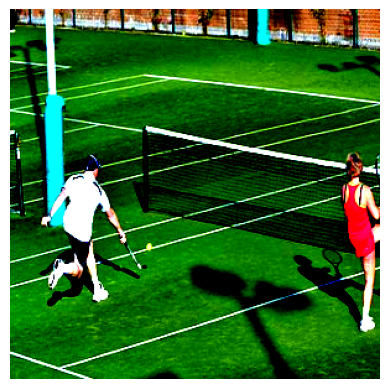

this is an image of a sporting match . the sport being played is tennis . there are two people on the court . the woman is wearing a pink tank top . the woman is wearing pink short shorts . the woman has short blonde hair . the court is green . the lines on the court are painted white . there is a white , green and black net .


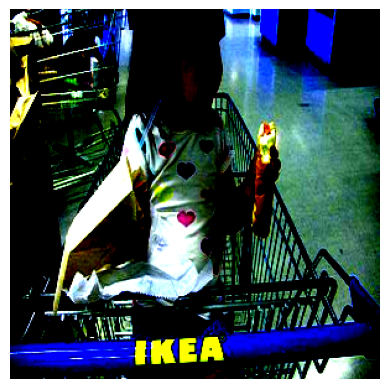

a little girl with blunt bangs is sitting in an ikea cart eating a hotdog . she is wearing a white shirt with pink , purple , beige , and yellow hearts on it . the cart is silver , with a blue handle that has ikea written on it . she has a straw in a cup in her right hand . there are boxes stacked one on top of each other on the left with chips inside . there is a card in front of her with other items in it .


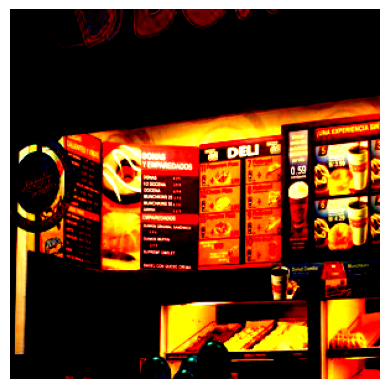

a menu is displayed . the menu is hanging from the wall inside of a restaurant . this is a dunkin donuts menu and some donuts are displayed under the menus .

Sample 1:


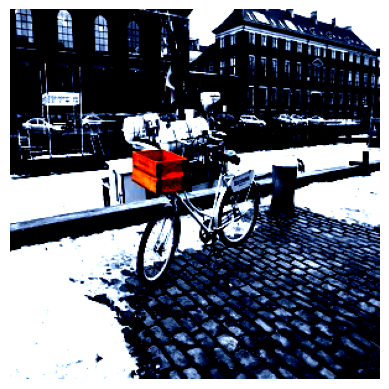

a bike is sitting on a stone paved walkway . the bike has an orange wooden crate sitting on the front of it . a small pile of snow is in front of the bike on the walkway . a snow covered road can be seen below the walkway . part of a vehicle is sitting near the walkway . there are tall buildings standing on the other side of the road . vehicles are parked in front of the buildings .


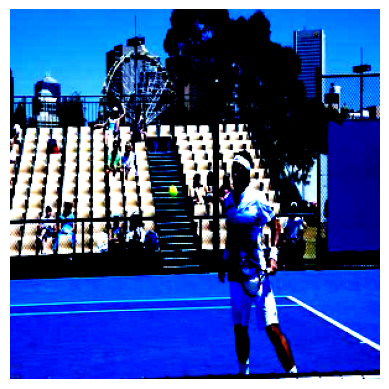

a tennis player stands on the court . the man has just hit the tennis ball . the man holds a tennis racket . the man wears a colorful shirt . there are a few people watch the game . the sky is blue and sunny . there is a <unk> wheel behind the stands . there is a tree by the <unk> wheel . the court is blue . there are tall buildings in the background .


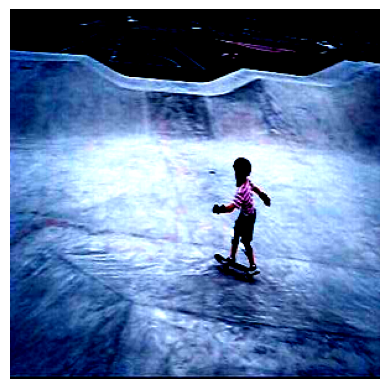

a young boy , dressed in knee-high shorts and a <unk> white short-sleeved shirt , <unk> around the skateboard <unk> . he is smart , as he has on both a helmet and white knee <unk> . he wears gloves , to protect his hands , and simple shoes . he seems to be alone , though in the distance he can see an open concrete lot and beyond that a parking lot and some cars .


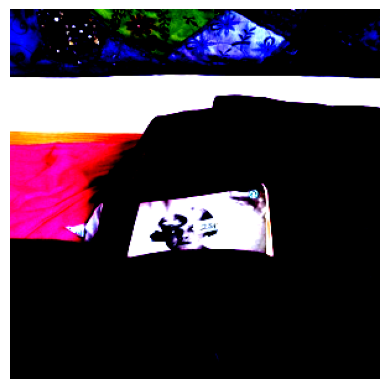

there is a bed with purple blankets on it . there is one purple pillow and one pink pillow on the bed . there is a blanket on the wall behind the bed . there is a book on top of the bed .

Sample 1:


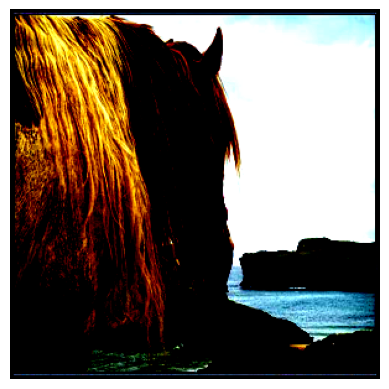

there is a horse standing in front of a body of water . there are black rocks on the ground with green moss and grass on top of the rocks . there are small waves in the water . the horse is white and brown and has a long mane on its head . there is a large red harness on the face of the horse . there are white clouds in the sky .


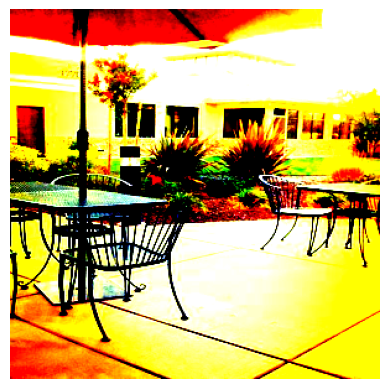

this is an image of a cafe patio . the tables are made of metal . the tables are black . the tables are mesh on top . the chairs are thin and black . the chairs at the table are metal . the chairs are black . the ground is light gray cement with black cracks . there is bark dust by the patio . the bark dust is white and brown .


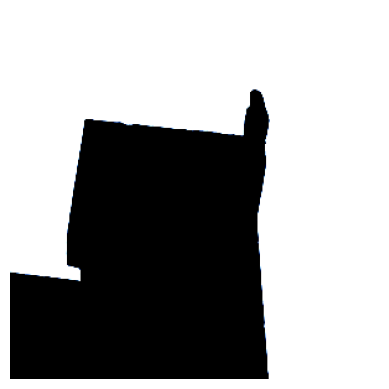

the bird is perched on the side of a ledge of a building . the building is dark colored . the building is made of bricks . the sky is cloudy and overcast . the bird is looking to the left . the sky is not blue at all . there is no sun shining outside . the sun is hiding behind the clouds . it is bright outside but there is no sun shining .


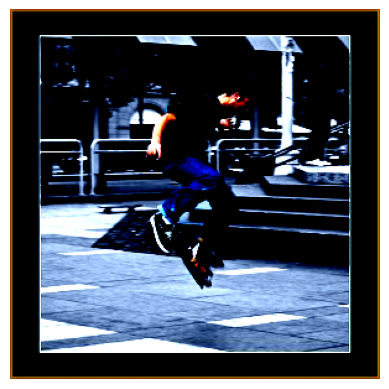

a man is doing a trick on his skateboard . he is in mid-air and appears to be doing a basic <unk> . he is wearing some typical blue jeans , a dark green tee shirt and his shoes are black and white . the bottom of his board is a black background with a colorful design displayed on it . the rest of the photograph is in black and white .



In [10]:
import matplotlib.pyplot as plt
import numpy as np
def generate_text_from_tensor(tensor, vocab):
    """Converts a tensor back into text."""
    # Iterate over each token in the tensor
    tokens = [vocab.lookup_token(token) for token in tensor]
    # Remove '<pad>' tokens and '<eos>' tokens (if any)
    tokens = [token for token in tokens if token != '<pad>' and token != '<eos>']
    # Concatenate the tokens into a single string
    text = ' '.join(tokens)
    return text
num_samples = 1
for i, (images, captions) in enumerate(train_data_loader):
    if i >= num_samples:
        break
    
    print(f"Sample {i + 1}:")
    for image, caption in zip(images, captions):
        # Convert the image tensor to a numpy array
        image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
        # Display the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        print(generate_text_from_tensor(caption,vocab))
    print()

for i, (images, captions) in enumerate(test_data_loader):
    if i >= num_samples:
        break
    
    print(f"Sample {i + 1}:")
    for image, caption in zip(images, captions):
        # Convert the image tensor to a numpy array
        image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
        # Display the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        print(generate_text_from_tensor(caption,vocab))
    print()
    
for i, (images, captions) in enumerate(validation_data_loader):
    if i >= num_samples:
        break
    
    print(f"Sample {i + 1}:")
    for image, caption in zip(images, captions):
        # Convert the image tensor to a numpy array
        image_np = image.permute(1, 2, 0).numpy()  # Change tensor shape from (C, H, W) to (H, W, C)
        
        # Display the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        print(generate_text_from_tensor(caption,vocab))
    print()


In [11]:
# num_samples = 1
# model.eval()
# # Iterate over the data loader and print random samples
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Prepare the input image
#         image = image.unsqueeze(0)  # Add batch dimension
#         # Forward pass
#         with torch.no_grad():
#             output = model(image)
        
#         # Print the output (or use it according to your requirement)
#         print("Output:", output)
#     print()

## Transformer Model

In [12]:
import torch
import torch.nn as nn

# Create a Transformer model
transformer_model = nn.Transformer(
    d_model=512,  # Dimension of the model
    nhead=8,      # Number of attention heads
    num_encoder_layers=6,  # Number of encoder layers
    num_decoder_layers=6,  # Number of decoder layers
    dim_feedforward=2048,  # Dimension of the feedforward network
    dropout=0.1,   # Dropout probability
    activation='relu'  # Activation function ('relu' or 'gelu')
)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
import torch.nn.init as init
class my_transformer(nn.Module):
    def __init__(self,n_tokens):
        super(my_transformer, self).__init__()
        self.transformer = nn.Transformer(
                                d_model=512,  # Dimension of the model
                                nhead=8,      # Number of attention heads
                                num_encoder_layers=6,  # Number of encoder layers
                                num_decoder_layers=6,  # Number of decoder layers
                                dim_feedforward=2048,  # Dimension of the feedforward network
                                dropout=0.1,   # Dropout probability
                                activation='relu'  # Activation function ('relu' or 'gelu')
                            )
        self.encoder = nn.Linear(n_tokens,512)
        self.decoder = nn.Linear(512,n_tokens)
        self._init_weights()

    def _init_weights(self):
        # Initialize encoder and decoder weights using Xavier initialization
        init.xavier_uniform_(self.encoder.weight)
        init.xavier_uniform_(self.decoder.weight)
        
    def forward(self,src,tgt):
        output = self.encoder(tgt)
        #print(output.shape,"Output shape")
        output = self.transformer(src,output)
        output = self.decoder(output)
        return output

In [14]:
# model.eval()
# transformer_model.eval()
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         with torch.no_grad():
#             embeddings = model(image.unsqueeze(0))
#         print(transformer_model(src=embeddings,tgt=caption))
#         break

model.eval()
n_tokens = len(vocab)
transformer_model = my_transformer(n_tokens)
transformer_model.eval()
model.to(device)
transformer_model.to(device)
for i, (images, captions) in enumerate(train_data_loader):
    if i >= num_samples:
        break
    print(images.shape)
    print(f"Sample {i + 1}:")
    for image, caption in zip(images, captions):
        # Convert the image tensor to a numpy array
        with torch.no_grad():
            embeddings = model(image.unsqueeze(0).to(device))
        
        # Clip the caption tensor to match the shape of the embeddings tensor
        #print(caption.shape)
        caption_length = min(caption.size(0), embeddings.size(1))
        clipped_caption = caption[:caption_length]
        print(embeddings.shape)
        print(clipped_caption.unsqueeze(0).shape)
        #clipped_caption = clipped_caption.float()
        one_hot_tensor = torch.zeros(512, n_tokens)
        one_hot_tensor[torch.arange(512), clipped_caption] = 1
        # Pass the embeddings and clipped caption tensors through the Transformer model
        output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
        
        # Print the output (you may need to decode the output into text)
        print(output.shape)
        print(output.view(-1,n_tokens).shape)
        break
import torch

def tensor_to_text(tensor, vocab):
    # Apply softmax along the second dimension (n_tokens)
    softmax_output = torch.softmax(tensor, dim=1)
    
    # Get the indices of the maximum value along the second dimension
    max_indices = torch.argmax(softmax_output, dim=1)
    
    # Convert the indices to text using the provided vocabulary
    text = [vocab.lookup_token(idx.item()) for idx in max_indices]
    
    return text

print(tensor_to_text(output.view(-1,n_tokens),vocab))

torch.Size([4, 3, 299, 299])
Sample 1:
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([512, 7697])
torch.Size([512, 7697])
['72', 'cops', '72', '72', 'cops', '72', 'cops', 'cops', '72', '72', '72', '72', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', '72', 'cops', '72', 'cops', 'cops', 'cops', 'cops', '72', 'cops', '72', '72', 'cops', 'cops', 'cops', '72', 'cops', 'cops', '72', 'cops', '72', '72', '72', '72', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', '72', 'cops', '72', 'cops', '72', '72', 'cops', 'cops', 'cops', '72', 'cops', 'cops', 'cops', '72', 'cops', '72', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'cops', 'c

In [15]:
model.to(device)
transformer_model.to(device)
model.train()
transformer_model.train()
import torch
import torch.nn as nn
import torch.optim as optim

transformer_model.train()
loss_function = nn.CrossEntropyLoss(ignore_index = vocab.__getitem__('<pad>'))
print(vocab.__getitem__('<pad>'))
optimizer = optim.Adam(transformer_model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    # Iterate over the dataset
    for i, (images, captions) in enumerate(train_data_loader):
        optimizer.zero_grad()
        loss=0
        for image, caption in zip(images, captions):
            image.to(device)
            caption.to(device)
            with torch.no_grad():
                embeddings = model(image.unsqueeze(0).to(device))
            caption_length = min(caption.size(0), embeddings.size(1))
            clipped_caption = caption[:caption_length]
            one_hot_tensor = torch.zeros(512, len(vocab))
            one_hot_tensor[torch.arange(512), clipped_caption] = 1
            output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
            loss += loss_function(output.view(-1, len(vocab)).to(device), clipped_caption.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(loss.item())
    
    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_data_loader)}")


1
36.1987419128418
31.65184783935547
29.005661010742188
29.771072387695312
35.487632751464844
36.72201919555664
37.46976852416992
29.42037582397461
28.049331665039062
28.11150360107422
28.076982498168945
28.477209091186523
28.641698837280273
26.489166259765625
27.94639778137207
28.114299774169922
27.079456329345703
26.22923469543457
29.38463592529297
27.657920837402344
25.258474349975586
24.545421600341797
24.9483585357666
23.9183292388916
23.028181076049805
27.685455322265625
25.35403823852539
26.545665740966797
25.10930633544922
24.429595947265625
23.087434768676758
23.501323699951172
24.36494255065918
25.409183502197266
23.924205780029297
22.80764389038086
23.18232536315918
23.239171981811523
26.002593994140625
24.705787658691406
23.26404571533203
23.718666076660156
24.288429260253906
23.739124298095703
21.734716415405273
23.096237182617188
21.212444305419922
21.355377197265625
23.78518295288086
22.760204315185547
22.153779983520508
23.01349449157715
24.170028686523438
22.4132575988

In [16]:
# model.to(device)
# transformer_model.to(device)
# model.train()
# transformer_model.train()
# import torch
# import torch.nn as nn
# import torch.optim as optim

# transformer_model.train()
# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# # Number of epochs
# num_epochs = 10

# # Training loop
# for epoch in range(num_epochs):
#     running_loss = 0.0
    
#     # Iterate over the dataset
#     for i, (images, captions) in enumerate(train_data_loader):
#         optimizer.zero_grad()
#             # Convert the image tensor to a numpy array
#         images.to(device)
#         captions.to(device)
#         with torch.no_grad():
#             embeddings = model(images.to(device))
#         #print(embeddings.unsqueeze(0).shape)
#         # Clip the caption tensor to match the shape of the embeddings tensor
#         caption_length = min(captions.size(1), embeddings.size(1))
#         #print(captions.shape)
#         clipped_captions = captions[:,:caption_length]
#         identity_matrix = torch.eye(7697)
#         one_hot_vector = identity_matrix[captions]
#         one_hot_vector = one_hot_vector.permute(1, 0, 2)
#         print(one_hot_vector.shape)
# #         one_hot_tensor[torch.arange(512), clipped_caption] = 1
# #         print(one_hot_tensor.shape)

#         # Forward pass
#         output = transformer_model(src=embeddings.to(device), tgt=one_hot_vector.to(device))

#         # Compute the loss
#         loss = loss_function(output.view(-1, len(vocab)).to(device), one_hot_tensor.to(device))

#         # Backward pass
#         loss.backward()

#         # Optimize
#         optimizer.step()

#         # Accumulate loss
#         running_loss += loss.item()
#         print(loss.item())
    
#     # Print average loss for the epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_data_loader)}")


In [17]:
# model.eval()
# transformer_model.eval()
# for i, (images, captions) in enumerate(train_data_loader):
#     if i >= num_samples:
#         break
    
#     print(f"Sample {i + 1}:")
#     for image, caption in zip(images, captions):
#         # Convert the image tensor to a numpy array
#         with torch.no_grad():
#             embeddings = model(image.unsqueeze(0))
#         print(transformer_model(src=embeddings,tgt=caption))
#         break

model.eval()
n_tokens = len(vocab)
#transformer_model = my_transformer(n_tokens)
transformer_model.eval()
model.to(device)
transformer_model.to(device)
for i, (images, captions) in enumerate(train_data_loader):
    if i >= num_samples:
        break
    print(images.shape)
    print(f"Sample {i + 1}:")
    for image, caption in zip(images, captions):
        # Convert the image tensor to a numpy array
        with torch.no_grad():
            embeddings = model(image.unsqueeze(0).to(device))
        
        # Clip the caption tensor to match the shape of the embeddings tensor
        #print(caption.shape)
        caption_length = min(caption.size(0), embeddings.size(1))
        clipped_caption = caption[:caption_length]
        print(embeddings.shape)
        print(clipped_caption.unsqueeze(0).shape)
        #clipped_caption = clipped_caption.float()
        one_hot_tensor = torch.zeros(512, n_tokens)
        one_hot_tensor[torch.arange(512), clipped_caption] = 1
        # Pass the embeddings and clipped caption tensors through the Transformer model
        output = transformer_model(src=embeddings.to(device), tgt=one_hot_tensor.to(device))
        
        # Print the output (you may need to decode the output into text)
        print(output.shape)
        print(output.view(-1,n_tokens).shape)
        break
import torch

def tensor_to_text(tensor, vocab):
    # Apply softmax along the second dimension (n_tokens)
    softmax_output = torch.softmax(tensor, dim=1)
    
    # Get the indices of the maximum value along the second dimension
    max_indices = torch.argmax(softmax_output, dim=1)
    
    # Convert the indices to text using the provided vocabulary
    text = [vocab.lookup_token(idx.item()) for idx in max_indices]
    
    return text

print(tensor_to_text(output.view(-1,n_tokens),vocab))

torch.Size([4, 3, 299, 299])
Sample 1:
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([512, 7697])
torch.Size([512, 7697])
['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 't